In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt','r').read().split()

In [3]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
len(words)

32033

In [8]:
chars = ''.join(sorted(list(set(''.join(words)))))

In [9]:
chars

'abcdefghijklmnopqrstuvwxyz'

In [10]:
itos = {}
stoi = {}
stoi['.'] = 0
itos[0] = '.'
for i,s in enumerate(chars):
    stoi[s] = i + 1
    itos[i+1] = s

In [52]:
block_size = 3
X,Y = [],[]


for w in words:
    print(w)
    context = [0]*block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]
    print(context)
    print(X)
    print(Y)
    break

yuheng
[14, 7, 0]
[[0, 0, 0], [0, 0, 25], [0, 25, 21], [25, 21, 8], [21, 8, 5], [8, 5, 14], [5, 14, 7]]
[25, 21, 8, 5, 14, 7, 0]


In [53]:
X = torch.tensor(X)
Y = torch.tensor(Y)

In [15]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1]])

In [16]:
Y

tensor([ 5, 13, 13,  1,  0])

In [17]:
def build_dataset(words):
    X = []
    Y = []
    block_size = 3
    for w in words:
        context = [0] * block_size
        for c in w + '.':
            ix = stoi[c]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y
            

In [19]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))


In [21]:
Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

In [25]:
Xtr.shape,Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [54]:
C = torch.randn((27,2))

In [55]:
emb = C[X]

In [56]:
X

tensor([[ 0,  0,  0],
        [ 0,  0, 25],
        [ 0, 25, 21],
        [25, 21,  8],
        [21,  8,  5],
        [ 8,  5, 14],
        [ 5, 14,  7]])

In [57]:
C[X]

tensor([[[-0.6741,  0.6101],
         [-0.6741,  0.6101],
         [-0.6741,  0.6101]],

        [[-0.6741,  0.6101],
         [-0.6741,  0.6101],
         [ 0.7455, -0.6417]],

        [[-0.6741,  0.6101],
         [ 0.7455, -0.6417],
         [ 0.0573, -0.6937]],

        [[ 0.7455, -0.6417],
         [ 0.0573, -0.6937],
         [-0.0830,  0.8226]],

        [[ 0.0573, -0.6937],
         [-0.0830,  0.8226],
         [-0.9749, -0.1916]],

        [[-0.0830,  0.8226],
         [-0.9749, -0.1916],
         [-1.4217, -0.4277]],

        [[-0.9749, -0.1916],
         [-1.4217, -0.4277],
         [ 0.3245, -0.2512]]])

In [58]:
emb.view(-1,6).shape

torch.Size([7, 6])

In [59]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [60]:
x  = emb.view(-1,6) @ W1 + b1

In [61]:
h = torch.tanh(x)

In [62]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [63]:
logits = h @ W2 + b2

In [64]:
logits.shape

torch.Size([7, 27])

In [65]:
counts = logits.exp()

In [66]:
probs = counts / counts.sum(dim=1,keepdims=True)

In [73]:
loss=-probs[torch.arange(len(Y)),Y].log().mean()

In [74]:
loss

tensor(12.3604)

In [76]:
sum(p.nelement() for p in parameters)

5827

In [145]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10),generator=g) # embedding
W1 = torch.randn((30,200),generator=g)
b1 = torch.randn(200,generator=g)
W2 = torch.randn((200,27),generator=g)
b2 = torch.rand(27,generator=g)
parameters = [C,W1,b1,W2,b2]
for p in parameters:
    p.requires_grad = True
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
def train(XX,YY):

    lri = []
    lossi = []
    stepi = []
    for i in range(200000):
        ix = torch.randint(0, Xtr.shape[0], (32,))

        emb = C[Xtr[ix]] # N,3,10
        h = torch.tanh(emb.view(-1,30) @ W1 + b1) # N,100
        logits = h @ W2 + b2  # N,27
        counts = logits.exp()
        probs = counts / counts.sum(dim=1,keepdims=True)
        loss = -probs[torch.arange(32),YY[ix]].log().mean()

        for p in parameters:
            p.grad = None

        loss.backward()

        lr = 0.1 if i < 100000 else 0.001
        for p in parameters:
            p.data += -lr*p.grad
        lri.append(lr)
        stepi.append(i)
        lossi.append(loss.log().item())
    return lri,lossi,stepi
    
#     print(loss.item())

In [146]:
lri,lossi,steoi=train(Xtr,Ytr)

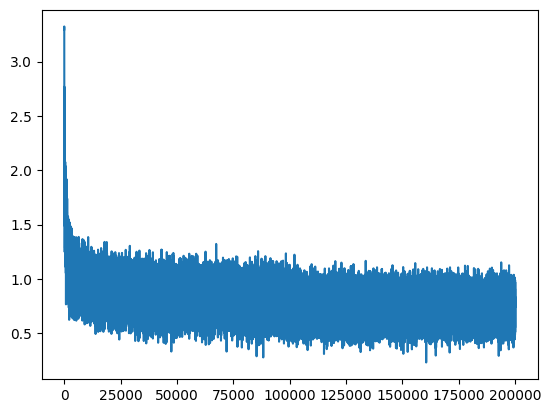

In [147]:
plt.plot(steoi,lossi)

In [148]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,30) @ W1 + b1) # N,100
logits = h @ W2 + b2  # N,27
counts = logits.exp()
probs = counts / counts.sum(dim=1,keepdims=True)
loss = -probs[torch.arange(len(Ytr)),Ydev[ix]].log().mean()
loss

tensor(2.5078, grad_fn=<NegBackward0>)

In [150]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30) @ W1 + b1) # N,100
logits = h @ W2 + b2  # N,27
counts = logits.exp()
probs = counts / counts.sum(dim=1,keepdims=True)
loss = -probs[torch.arange(len(Ydev)),Ydev[ix]].log().mean()
loss

tensor(2.4976, grad_fn=<NegBackward0>)

In [151]:
emb = C[Xte]
h = torch.tanh(emb.view(-1,30) @ W1 + b1) # N,100
logits = h @ W2 + b2  # N,27
counts = logits.exp()
probs = counts / counts.sum(dim=1,keepdims=True)
loss = -probs[torch.arange(len(Yte)),Yte[ix]].log().mean()
loss

tensor(5.1741, grad_fn=<NegBackward0>)

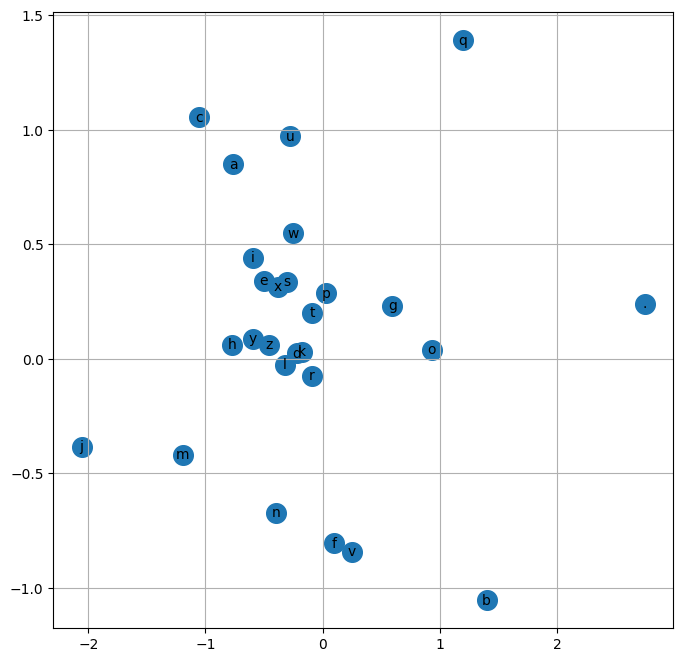

In [152]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data,C[:,1].data,s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0],C[i,1],itos[i],ha='center',va='center')
plt.grid('minor')

In [161]:
for _ in range(100):
    
    
    context = [0]*3
    word = []
    while True:
        emb = C[torch.tensor(context).view(-1,3)] # 1,3,10
        h = torch.tanh(emb.view(-1,30) @ W1 + b1)
        logits = h @ W2 + b2
        counts = logits.exp()
        probs = counts / counts.sum(dim=1,keepdims=True)
        ix = torch.multinomial(probs,num_samples=1).item()
        word.append(itos[ix])
        context = context[1:]+[ix]
        if ix == 0:
            break
    print(''.join(word))

valeou.
tyana.
noe.
cosi.
fex.
cras.
kassynce.
basson.
lhy.
kemanya.
tami.
nalah.
dadeen.
editon.
malvann.
alainlennley.
maxton.
rubela.
hatt.
rivero.
dake.
miia.
brimia.
kayci.
dane.
ren.
malianah.
jebrae.
cipser.
dafton.
kenganaan.
jurn.
gile.
muroheya.
emidianna.
tasponelijahita.
lenniel.
kamarcerick.
emmanirysella.
maxuma.
amar.
khy.
counny.
anni.
denna.
aubryn.
katon.
azlee.
falir.
eritory.
abdan.
bailamileinie.
lean.
julionniallalynn.
elon.
jakauazhrerz.
esza.
mehris.
kalosy.
mail.
hawan.
yveryserrn.
brie.
matkalynna.
kalla.
torta.
tie.
amirilad.
azz.
harloue.
jaya.
iblee.
blacheeman.
ela.
kyriah.
amis.
auronya.
ashra.
able.
elh.
palayya.
mareith.
milose.
ash.
jan.
lyzeer.
dreish.
makaiia.
cisanysa.
moon.
dydiny.
lilyn.
jusleigh.
xua.
semonsan.
hayuelley.
haana.
eriyhan.
mararil.
jago.


In [163]:
XX = C.detach().numpy()

In [166]:
from sklearn.decomposition import PCA

In [167]:
pca = PCA(n_components=2)

In [168]:
pca.fit(XX)

PCA(n_components=2)

In [170]:
new_XX=pca.fit_transform(XX)

In [173]:
pca.explained_variance_ratio_

array([0.3112145 , 0.22356692], dtype=float32)

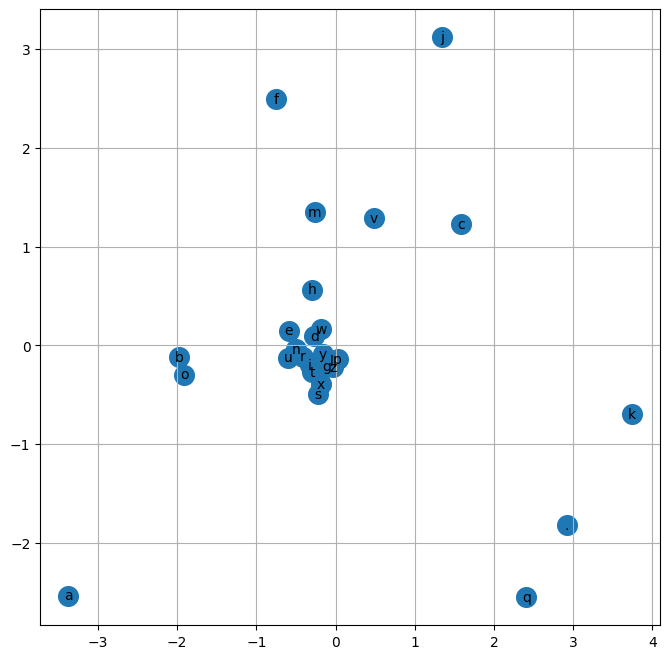

In [171]:
plt.figure(figsize=(8,8))
plt.scatter(new_XX[:,0].data,new_XX[:,1].data,s=200)
for i in range(new_XX.shape[0]):
    plt.text(new_XX[i,0],new_XX[i,1],itos[i],ha='center',va='center')
plt.grid('minor')